# TD 7: Analyse de logs

Dans cette activité on va faire une analyse de fichiers de log.
Pour cela on a récupéré 75Mo du service système SSHD, qui gère les connections entrantes SSH.
Un échantillon du fichier (2000 lignes) est disponible sur la page Moodle du cours, et l'ensemble des logs peut être obtenu de la plateforme [Zenodo](https://zenodo.org/record/3227177#.Y4jQZuzMKuU)
Ici on a découpé le gros fichier obtenu de Zenodo en une trentaine de fichiers plus petits, un par jour. Ceci ressemble à ce qu'on trouverait dans un contexte réel.

On peut voir la liste de fichiers en faisant ```listdir```:

In [1]:
import os
os.chdir("../log files/ssh_logs/")
os.listdir(".")

['SSHDec31.log',
 'SSHDec19.log',
 'SSHJan4.log',
 'SSHJan5.log',
 'SSHDec18.log',
 'SSHDec30.log',
 'SSHDec26.log',
 'SSHJan7.log',
 'SSHJan6.log',
 'SSHDec23.log',
 'SSHJan2.log',
 'SSHJan3.log',
 'SSHDec22.log',
 'SSHDec20.log',
 'SSHJan1.log',
 'SSHDec21.log',
 'SSHDec10.log',
 'SSHDec11.log',
 'SSHDec13.log',
 'SSHDec12.log',
 'SSHDec16.log',
 'SSHDec17.log',
 'SSHDec29.log',
 'SSHDec15.log',
 'SSHDec14.log']

On est maintenant dans le répertoire avec les fichiers de logs.
On peut ouvrir l'un d'entre eux et lire les 20 premières lignes pour avoir une idée du contenu:

In [2]:
with open("SSHDec15.log", "r") as f:
    for i in range(20):
        print(f.readline(), end="") # on enleve le retour a la ligne car il y en a deja un dans le texte a afficher
    

Dec 15 00:01:22 LabSZ sshd[11303]: Invalid user import from 2.239.208.154
Dec 15 00:01:22 LabSZ sshd[11303]: input_userauth_request: invalid user import [preauth]
Dec 15 00:01:22 LabSZ sshd[11303]: pam_unix(sshd:auth): check pass; user unknown
Dec 15 00:01:22 LabSZ sshd[11303]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=2-239-208-154.ip250.fastwebnet.it 
Dec 15 00:01:29 LabSZ sshd[11303]: Failed password for invalid user import from 2.239.208.154 port 47972 ssh2
Dec 15 00:01:30 LabSZ sshd[11303]: fatal: Read from socket failed: Connection reset by peer [preauth]
Dec 15 00:04:18 LabSZ sshd[11305]: Invalid user zhangw from 175.102.13.6
Dec 15 00:04:18 LabSZ sshd[11305]: input_userauth_request: invalid user zhangw [preauth]
Dec 15 00:04:18 LabSZ sshd[11305]: pam_unix(sshd:auth): check pass; user unknown
Dec 15 00:04:18 LabSZ sshd[11305]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=175.102.13.6 
Dec 15

On remarque qu'un grand nombre de tentatives de connections échoue. On voit plusieurs lignes de la forme
```
Dec 15 00:04:21 LabSZ sshd[11305]: Failed password for invalid user zhangw from 175.102.13.6 port 60365 ssh2
```
Il est probable que ces connections soient presque toutes des tentatives d'intrusion.
Supposons qu'on veuille répertorier les addresses IP qui tentent de se connecter ainsi. Le log étant généré automatiquement, on peut compter sur le fait que le format des lignes soit consistant dans l'ensemble du fichier.
On peut découper les mots d'une ligne avec ```split()```, et identifier les lignes avec "Failed password" aux positions 5 et 6:

In [10]:
with open("SSHDec15.log", "r") as f:
    for i in range(60):
        ligne = f.readline()
        mots = ligne.split() # decouper la chaine de caracteres en mots (avec les espaces comme séparateurs)
        if (mots[5]=="Failed" and mots[6]=="password"): #échec de connection
            print(ligne, end="") # on enleve le retour a la ligne car il y en a deja un dans le texte a afficher


Dec 15 00:01:29 LabSZ sshd[11303]: Failed password for invalid user import from 2.239.208.154 port 47972 ssh2
Dec 15 00:04:21 LabSZ sshd[11305]: Failed password for invalid user zhangw from 175.102.13.6 port 60365 ssh2
Dec 15 00:05:19 LabSZ sshd[11307]: Failed password for root from 124.126.145.182 port 56344 ssh2
Dec 15 00:11:41 LabSZ sshd[11325]: Failed password for invalid user support from 212.83.158.199 port 63650 ssh2
Dec 15 00:18:40 LabSZ sshd[11331]: Failed password for invalid user byyl from 115.71.16.143 port 42795 ssh2
Dec 15 00:26:08 LabSZ sshd[11336]: Failed password for invalid user 123 from 185.222.209.151 port 53265 ssh2
Dec 15 00:27:50 LabSZ sshd[11339]: Failed password for invalid user wangx from 52.80.34.196 port 28028 ssh2
Dec 15 00:28:40 LabSZ sshd[11342]: Failed password for root from 119.7.221.129 port 49005 ssh2
Dec 15 00:28:43 LabSZ sshd[11344]: Failed password for root from 119.7.221.129 port 51205 ssh2
Dec 15 00:28:45 LabSZ sshd[11346]: Failed password for ro

On peut voir que pour des connections échouées, il y a deux formats: celui donné au-dessus, quand le nom d'utilisateur est inconnu ("invalid user"), et un autre légèrement différent quand le nom d'utilisateur est valide (comme "root"):
```
Dec 15 00:05:19 LabSZ sshd[11307]: Failed password for root from 124.126.145.182 port 56344 ssh2
```

Pour distinguer les deux cas, on peut voir si les mots aux positions 8 et 9 sont "invalid user" ou non. On récupère ensuite l'adresse IP d'origine, en comptant les positions:

In [41]:
with open("SSHDec15.log", "r") as f:
    for i in range(60):
        ligne = f.readline()
        mots = ligne.split() # decouper la chaine de caracteres en mots (avec les espaces comme séparateurs)
        if (mots[5]=="Failed" and mots[6]=="password"): #échec de connection
            if(mots[8]=="invalid" and mots[9]=="user"):
                ip = mots[12]
            else:
                ip = mots[10]
            print("connection depuis", ip)


connection depuis 2.239.208.154
connection depuis 175.102.13.6
connection depuis 124.126.145.182
connection depuis 212.83.158.199
connection depuis 115.71.16.143
connection depuis 185.222.209.151
connection depuis 52.80.34.196
connection depuis 119.7.221.129
connection depuis 119.7.221.129
connection depuis 119.7.221.129


On peut collecter dans une liste les adresses IP des 'attaquants': on pourrait envisager de bloquer certaines connections en fonction des adresses IP d'origine, par exemple.

In [42]:
liste_IP = []
with open("SSHDec15.log", "r") as f:
    for i in range(60):
        ligne = f.readline()
        mots = ligne.split() # decouper la chaine de caracteres en mots (avec les espaces comme séparateurs)
        if (mots[5]=="Failed" and mots[6]=="password"): #échec de connection
            if(mots[8]=="invalid" and mots[9]=="user"):
                ip = mots[12]
            else:
                ip = mots[10]
            print("connection depuis", ip)
            liste_IP.append(ip)
print("addresses IP d'origine:")
print(', '.join(liste_IP))

connection depuis 2.239.208.154
connection depuis 175.102.13.6
connection depuis 124.126.145.182
connection depuis 212.83.158.199
connection depuis 115.71.16.143
connection depuis 185.222.209.151
connection depuis 52.80.34.196
connection depuis 119.7.221.129
connection depuis 119.7.221.129
connection depuis 119.7.221.129
addresses IP d'origine:
2.239.208.154, 175.102.13.6, 124.126.145.182, 212.83.158.199, 115.71.16.143, 185.222.209.151, 52.80.34.196, 119.7.221.129, 119.7.221.129, 119.7.221.129


On peut maintenant réduire l'affichage et faire l'analyse sur l'ensemble du fichier:

In [43]:
liste_IP = []
with open("SSHDec15.log", "r") as f:
    for ligne in f: # on énumère toutes les lignes du fichier
        mots = ligne.split() # decouper la chaine de caracteres en mots (avec les espaces comme séparateurs)
        if (mots[5]=="Failed" and mots[6]=="password"): #échec de connection
            if(mots[8]=="invalid" and mots[9]=="user"):
                ip = mots[12]
            else:
                ip = mots[10]
            #print("connection depuis", ip)
            liste_IP.append(ip)
print("addresses IP d'origine:")
print(', '.join(liste_IP[:100])) # on affiche seulement les 100 premier éléments de la liste

addresses IP d'origine:
2.239.208.154, 175.102.13.6, 124.126.145.182, 212.83.158.199, 115.71.16.143, 185.222.209.151, 52.80.34.196, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129, 119.7.221.129

On voit qu'il y a énormément de répétition dans la listes obtenues. Plutôt que de répéter les mêmes adresses IP de nombreuses fois, on peut compter combien de fois elles sont utilisées, et garder l'information dans un dictionnaire. Pour ceci une fonctionnalité utile des dictionnaires est la méthode ```get```: cette méthode nous permet d'obtenir la valeur associée à une clé, et de gérer (simultanément) le cas où la clé n'est pas présente dans le dictionnaire, en fournissant une valeur par défaut.

Voyons ce qu'il se passe sans ```get```, quand on cherche à obtenir la valeur à une clé qui n'existe pas encore dans le dictionnaire:

In [19]:
exemple={'a':1, 'b':2}
print(exemple['c'])

KeyError: 'c'

Avec ```get```, on peut obtenir soit la valeur du dictionnaire, soit une valeur par défaut:

In [23]:
exemple.get('b', 10)

2

In [24]:
exemple.get('c', 10)

10

Dans le problème qui nous intéresse, les valeurs seront les comptes du nombre de fois qu'apparaissent les clés; on peut donc considérer que s'ils ne sont pas encore dans le dictionnaire c'est comme s'ils y étaient, avec la valeur 0.

In [29]:
exemple['a'] = exemple.get('a',0) + 1
exemple['b'] = exemple.get('b',0) + 1
exemple['c'] = exemple.get('c',0) + 1

In [30]:
exemple

{'a': 2, 'b': 5, 'c': 2}

On a rajouté 1 aux valeurs associées à ```'a'``` et ```'b'```, et pour ```'c'``` qui n'était pas dans le dictionnaire, on a ajouté 1 à la valeur par défaut 0.

On applique cette technique pour compter les occurences des différentes adresses IP et noms d'utilisateurs:

In [44]:
liste_IP = {} # dictionnaire vide
with open("SSHDec15.log", "r") as f:
    for ligne in f: # on énumère toutes les lignes du fichier
        mots = ligne.split() # decouper la chaine de caracteres en mots (avec les espaces comme séparateurs)
        if (mots[5]=="Failed" and mots[6]=="password"): #échec de connection
            if(mots[8]=="invalid" and mots[9]=="user"):
                ip = mots[12]
            else:
                ip = mots[10]
            #print("connection depuis", ip)
            liste_IP[ip] = liste_IP.get(ip,0) + 1 # comptage
print("---------- addresses IP d'origine:")
# obtenir une représentation des paires clés-valeurs
paires = [ k+" : compte="+str(v) for k,v in liste_IP.items()]
print('\n'.join(paires)) # affichage de la liste sur des lignes différentes (retour à la ligne comme séparateur)

---------- addresses IP d'origine:
2.239.208.154 : compte=3
175.102.13.6 : compte=7
124.126.145.182 : compte=1
212.83.158.199 : compte=1
115.71.16.143 : compte=57
185.222.209.151 : compte=24
52.80.34.196 : compte=12
119.7.221.129 : compte=105
117.107.159.146 : compte=1
201.255.25.93 : compte=1
103.79.141.173 : compte=4
163.172.157.212 : compte=8
61.143.3.203 : compte=5
51.15.199.186 : compte=12
46.48.198.83 : compte=1
5.188.10.180 : compte=35
124.68.10.20 : compte=36
183.136.162.51 : compte=5
202.92.128.175 : compte=6
195.154.63.158 : compte=2
182.45.92.120 : compte=1
103.207.39.212 : compte=7
103.204.70.183 : compte=6
14.116.171.251 : compte=2231
118.85.194.26 : compte=1
51.15.220.221 : compte=8
180.169.107.150 : compte=1
181.214.87.4 : compte=5
207.204.204.84 : compte=2
87.120.255.141 : compte=1
113.175.93.230 : compte=1
197.211.243.136 : compte=1
14.162.164.196 : compte=1
103.207.36.21 : compte=2
46.125.36.243 : compte=6
140.255.91.140 : compte=1
101.71.29.235 : compte=1
61.153.56.3

Ça fait beaucoup: on peut se limiter aux aqdresses et noms qui apparaissent plus que 10 fois. On peut utiliser ici une clause supplémentaire ```if``` dans la compréhension de liste:

In [35]:
paires = [ k+" : compte="+str(v) for k,v in liste_IP.items() if v>=10]

In [36]:
print('\n'.join(paires)) # affichage de la liste sur des lignes différentes (retour à la ligne comme séparateur)

115.71.16.143 : compte=57
185.222.209.151 : compte=24
52.80.34.196 : compte=12
119.7.221.129 : compte=105
51.15.199.186 : compte=12
5.188.10.180 : compte=35
124.68.10.20 : compte=36
14.116.171.251 : compte=2231
103.99.0.122 : compte=60
123.235.32.19 : compte=38
185.165.29.140 : compte=24
173.239.228.96 : compte=19
212.237.41.152 : compte=33
183.238.25.86 : compte=2065
58.221.249.102 : compte=153
119.7.221.137 : compte=34
159.203.87.8 : compte=15


## Partie II: Exercice guidé - consolider l'ensemble de l'analyse sur les différents fichiers

Dans cette partie on va étendre l'analyse faite ici à l'ensemble des 25 fichiers de logs, et sauvegarder les résultats dans un nouveau fichier.

Pour cet exercice il est nécessaire de collecter les fichiers de log, qui sont disponibles sur Moodle.

__2.1__ Commençons par préparer le code pour lire tous les fichiers les uns après les autres. Écrire une boucle qui énumère les fichiers de log, et affiche la première ligne de chaque fichier.

__2.2__ Reprendre l'ensemble du code vu au-dessus pour compter les adresses IP utilisées. Attention: les comptages doivent être consolidés pour toute la période.

__2.3__ En affichant les premières lignes de tous les fichiers, on peut remarquer dans certains fichiers (ex: le 1er Janvier) des lignes de la forme:
```
Jan  1 22:38:31 LabSZ sshd[16315]: message repeated 3 times: [ Failed password for root from 218.65.30.30 port 52352 ssh2]
```
Ceci indique qu'il y a eu 3 fois 'Failed password...', soit 3 tentatives de connection pour la même adresse Ip et le même nom d'utilisateur. Ajouter du code pour comptabiliser ces connections (attention: pour cette ligne il faut comptabiliser l'adresse IP 3 fois, et dans d'autres cas 5 fois, etc. selon le nombre de répétitions indiqué).

__2.4__ Ici on s'est limité à répertorier les addresses IP d'origine des connections. Il est aussi pertinent de répertorier les noms d'utilisateurs ciblés, afin de savoir quels mots de passe sont les plus importants à sécuriser (changer fréquemment, utiliser une grande longueur et des caractères spéciaux, etc.)

Ajouter du code pour compter les connections sur les différents noms d'utilisateurs.

__2.5__ On veut sauvegarder l'information dans des fichiers (un fichier pour les adresses IP, un fichier pour les noms d'utilisateur). Ajouter du code pour ouvrir un fichier "adressesIP.txt" et sauvegarder la liste des adresses IP / comptes (une par ligne), et un fichier semblable pour les noms d'utilisateur.

## Partie III - Exercice non guidé: l'évolution des attaques dans le temps. 

L'analyse précédente avait pour but de collecter des informations sur les tentatives d'intrusion (les adresses IP d'ou elles proviennent, les noms d'utilisateurs ciblés), sur l'ensemble des données.

Dans cet exercice le but est plutôt de voir comment se répartissent les tenatives d'intrusion dans le temps.
On voudrait savoir si elles surviennent plutôt la nuit, le matin, l'apres-midi... 
Pour ceci on voudrait pour chaque jour dans les données, collecter les heures auxquelles les tentatives d'intrusion se produisent. On aimerait ensuite diviser la journée en 24h et tracer une courbe qui montre la proportion des tentatives d'intrusion qui se produisent à chaque heure de la journée.

D'autre part, on peut observer dans les logs, des connections réussies. Les lignes ont la forme suivante:
```
Dec 17 15:02:50 LabSZ sshd[4627]: Accepted password for fztu from 119.137.63.195 port 53927 ssh2
```
On peut aussi tracer le nombre de connections réussies (a priori légitimes) dans la journée, et comparer les deux courbes.

Indications pour le tracé des courbes:
Il est nécessaire d'avoir un ensemble de données de la forme ```(x, y)```, soit un ensemble de paires ```(heure, nombre de connection)```, pour heure = \[0, 2, 3,... 23\]. 

On peut ensuite utiliser la bibliothèque ```matplotlib```, en adaptant l'exemple suivant:

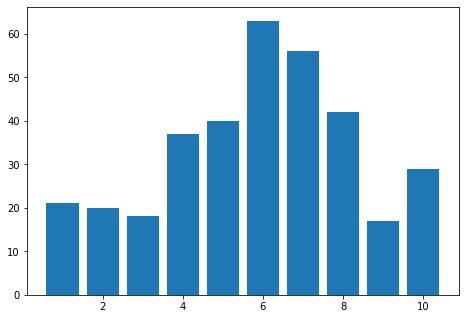

In [49]:
import matplotlib.pyplot as plt
# exemple de données
donnees = [(1, 21), (2,20), (3, 18), (4, 37), (5,40), (6,63), (7,56), (8, 42), (9, 17), (10, 29)]
x =[a[0] for a in donnees]
y =[a[1] for a in donnees]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()